## Importing Libraries and packages

In [1]:
# import libraries
import pandas as pd
pd.options.display.max_columns = 50
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
sns.set()

# packages for data cleaning function
import re
import string


# packages for NLP preprocessing
import nltk
# nltk.download('punkt')
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *

from wordcloud import WordCloud

import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score  


## Data Cleaning

### Read Data

In [2]:
# Read a CSV file into a DataFrame and assign it to the variable 'df'.
df = pd.read_csv('U:/Lip22pri/Dissertation/labeled_data.csv', index_col=0)

# Display the first few rows (default is 5 rows) of the DataFrame 'df' to inspect the data.
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Anonymize Data

In [3]:
#function to anonymise
def anon(text):
     # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    
    return text

round1 = lambda x: anon(x)

#applying data cleaning function to 'tweet' column
df['anon_tweets'] = df['tweet'].apply(round1)
del df['tweet']
df.head()

,count,hate_speech,offensive_language,neither,class,anon_tweets
0,3,0,0,3,2,!!! RT As a woman you shouldn't complain abou...
1,3,0,3,0,1,!!!!! RT boy dats cold...tyga dwn bad for cuf...
2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...
3,3,0,2,1,1,!!!!!!!!! RT she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT The shit you hear about me m...


### Dropping duplicate tweets if any

In [4]:
# Remove duplicate rows from the DataFrame 'df' based on the 'anon_tweets' column.
# This will keep only the first occurrence of each unique 'anon_tweets' value.
df =df.drop_duplicates('anon_tweets')

# Display the first few rows (default is 5 rows) of the DataFrame 'df' after removing duplicates.
df.head()

,count,hate_speech,offensive_language,neither,class,anon_tweets
0,3,0,0,3,2,!!! RT As a woman you shouldn't complain abou...
1,3,0,3,0,1,!!!!! RT boy dats cold...tyga dwn bad for cuf...
2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...
3,3,0,2,1,1,!!!!!!!!! RT she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT The shit you hear about me m...


### Checking distribution of column 'Class'

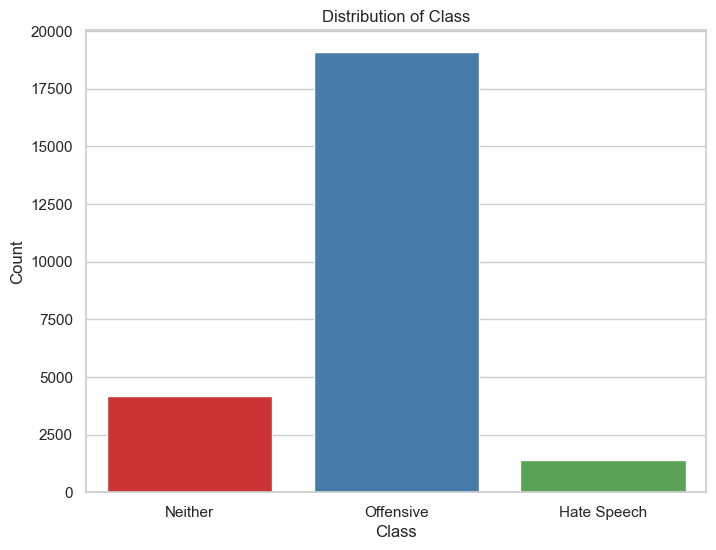

In [5]:
# Mapping class labels to their corresponding textual descriptions.
class_labels = {0: 'Hate Speech', 1: 'Offensive', 2: 'Neither'}

# Creating a new column 'class_label' in the DataFrame 'df' by mapping the 'class' column using the 'class_labels' dictionary.
df['class_label'] = df['class'].map(class_labels)

# Setting the style of the seaborn plots to "whitegrid."
sns.set(style="whitegrid")

# Creating a new figure with a specified size (8x6 inches).
plt.figure(figsize=(8, 6))

# Creating a count plot using seaborn to visualize the distribution of classes in the DataFrame 'df'.
# The x-axis represents 'class_label', and the color palette is set to 'Set1'.
sns.countplot(data=df, x='class_label', palette='Set1')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.title('Distribution of Class')

# Save the plot to a file
plt.savefig('U:/Lip22pri/Dissertation/orig_class_imbalance.png', bbox_inches='tight', pad_inches=1)

# Show the plot
plt.show()

In [6]:
# Display the first few rows (default is 5 rows) of the DataFrame 'df' to inspect the data.
df.head()

,count,hate_speech,offensive_language,neither,class,anon_tweets,class_label
0,3,0,0,3,2,!!! RT As a woman you shouldn't complain abou...,Neither
1,3,0,3,0,1,!!!!! RT boy dats cold...tyga dwn bad for cuf...,Offensive
2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...,Offensive
3,3,0,2,1,1,!!!!!!!!! RT she look like a tranny,Offensive
4,6,0,6,0,1,!!!!!!!!!!!!! RT The shit you hear about me m...,Offensive


### Creating a new column 'Label' for binary hate speech values.

Creating a new column based on the values in the 'class' column.

In the original dataset, 'class' is categorized as follows: 0 -  Hate Speech, 1 -  Offensive speecg, and 2 -  Neither.

We are replacing the values from the 'class' column in the new column 'label' to represent 1 for hate speech and 0 for other categories.

In [7]:
# Replace values in the 'class' column to map them to a different label scheme.

# Replace all occurrences of 1 with 2 in the 'class' column and store the result in the 'label' column.
df['label'] = df['class'].replace(1,2)

# Replace all occurrences of 0 with 1 in the 'label' column. This effectively swaps the labels 0 and 1.
df['label'] = df['label'].replace(0,1)

# Replace all occurrences of 2 with 0 in the 'label' column.
df['label'] = df['label'].replace(2,0)

# Display the first few rows (default is 5 rows) of the DataFrame 'df' after replacing values.
df.head()

,count,hate_speech,offensive_language,neither,class,anon_tweets,class_label,label
0,3,0,0,3,2,!!! RT As a woman you shouldn't complain abou...,Neither,0
1,3,0,3,0,1,!!!!! RT boy dats cold...tyga dwn bad for cuf...,Offensive,0
2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...,Offensive,0
3,3,0,2,1,1,!!!!!!!!! RT she look like a tranny,Offensive,0
4,6,0,6,0,1,!!!!!!!!!!!!! RT The shit you hear about me m...,Offensive,0


### Checking distribution of column 'Label'

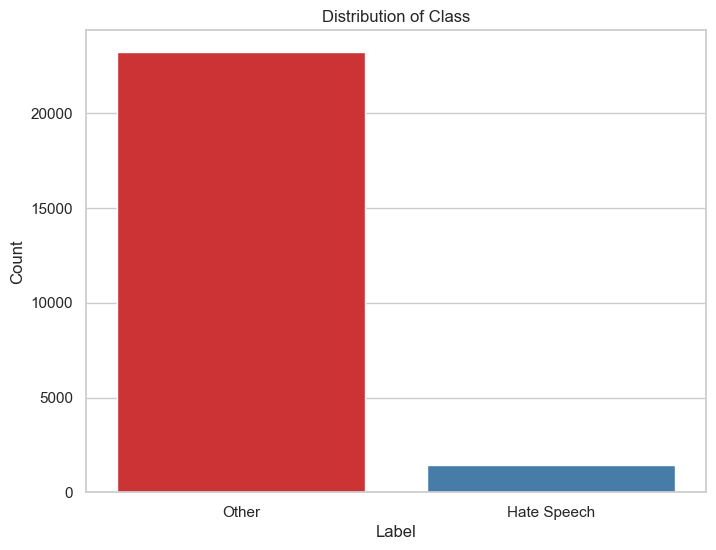

In [8]:
#Mapping labels with values
label_labels = {0: 'Other', 1: 'Hate Speech'}
df['label_label'] = df['label'].map(label_labels)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create the count plot
sns.countplot(data=df, x='label_label', palette='Set1')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Label')

# Add title
plt.title('Distribution of Class')

# Save the plot to a file
plt.savefig('U:/Lip22pri/Dissertation/cleaned_class_imbalance.png', bbox_inches='tight', pad_inches=1)

# Show the plot
plt.show()

In [9]:
df.head()

,count,hate_speech,offensive_language,neither,class,anon_tweets,class_label,label,label_label
0,3,0,0,3,2,!!! RT As a woman you shouldn't complain abou...,Neither,0,Other
1,3,0,3,0,1,!!!!! RT boy dats cold...tyga dwn bad for cuf...,Offensive,0,Other
2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...,Offensive,0,Other
3,3,0,2,1,1,!!!!!!!!! RT she look like a tranny,Offensive,0,Other
4,6,0,6,0,1,!!!!!!!!!!!!! RT The shit you hear about me m...,Offensive,0,Other


### Creating new dataframe with renamed columns

Modifications made to the original DataFrame include removing the 'class' column, renaming 'count' to 'total_votes', renaming 'hate_speech' to 'hate_speech_votes', and aggregating 'offensive_language' and 'neither' to create the 'other_votes' column.

In [10]:
# Creating a new DataFrame as a copy of the original one.
# Dropping the 'class' column in this new DataFrame.
raw_df = df[['count', 'hate_speech', 'offensive_language', 'neither', 'anon_tweets', 'label']].copy()

# Renaming the 'count' column to 'total_votes' and the 'hate_speech' column to 'hate_speech_votes'.
raw_df.rename(columns={'count':'total_votes', 'hate_speech':'hate_speech_votes',},inplace=True)

# Creating a new column 'other_votes' by combining the 'offensive_language' and 'neither' columns.
# This column represents votes that are neither hate speech nor offensive language.
raw_df['other_votes'] = raw_df['offensive_language'] + raw_df['neither']

# Reordering the columns for clarity.
raw_df = raw_df.reindex(columns=['total_votes', 'hate_speech_votes', 'other_votes', 'label', 'anon_tweets'])

raw_df.head()

,total_votes,hate_speech_votes,other_votes,label,anon_tweets
0,3,0,3,0,!!! RT As a woman you shouldn't complain abou...
1,3,0,3,0,!!!!! RT boy dats cold...tyga dwn bad for cuf...
2,3,0,3,0,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...
3,3,0,3,0,!!!!!!!!! RT she look like a tranny
4,6,0,6,0,!!!!!!!!!!!!! RT The shit you hear about me m...


### Cleaning Tweets

In [11]:
clean_df = raw_df.copy()

# function to clean all data
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # string.punctuation is a string of all punctuation marks
    # so this gets rid of all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)

    return text

round2 = lambda x: clean_text_round1(x)

#applying data cleaning function to 'tweet' column
clean_df['anon_tweets'] = clean_df['anon_tweets'].apply(round2)
clean_df.rename(columns={'anon_tweets':'cleaned_tweets', },inplace=True)
clean_df.head()


,total_votes,hate_speech_votes,other_votes,label,cleaned_tweets
0,3,0,3,0,as a woman you shouldnt complain about clean...
1,3,0,3,0,boy dats coldtyga dwn bad for cuffin dat hoe...
2,3,0,3,0,dawg you ever fuck a bitch and she sta to c...
3,3,0,3,0,she look like a tranny
4,6,0,6,0,the shit you hear about me might be true or ...


## Pre-Processing

### Creating new column 'censor_tweet' copy of cleaned column to censore hate words.


In [12]:
# Creating a new column 'censor_tweets' in the 'clean_df' DataFrame
# and populating it with the values from the 'cleaned_tweets' column.
clean_df['censor_tweets'] = clean_df['cleaned_tweets']

### Censoring tweets

In [13]:
# Define a dictionary 'replacements' to specify character replacements.
replacements = { 'bitch':'b**ch', 'bitches':'b**ches', 'nigga':'n**ga', 'nigger':'ni**er', 'ass':'a*s', 'hoe':'h*e', 'hoes':'h**s', 'faggot':'fa**ot', 'faggots':'fa**ots', 'fuck':'f**k','fucking':'f**king', 'pussy':'p**sy', 'fag':'f*g', 'shit':'sh*t' }

# Iterate through the key-value pairs in 'replacements'.
# For each pair, apply the string replacement operation to the 'censor_tweets' column
# in the 'clean_df' DataFrame.
for k, v in replacements.items():
    clean_df['censor_tweets'] = clean_df['censor_tweets'].str.replace(k, v)
        
clean_df.head()

,total_votes,hate_speech_votes,other_votes,label,cleaned_tweets,censor_tweets
0,3,0,3,0,as a woman you shouldnt complain about clean...,as a woman you shouldnt complain about clean...
1,3,0,3,0,boy dats coldtyga dwn bad for cuffin dat hoe...,boy dats coldtyga dwn bad for cuffin dat h*e...
2,3,0,3,0,dawg you ever fuck a bitch and she sta to c...,dawg you ever f**k a b**ch and she sta to c...
3,3,0,3,0,she look like a tranny,she look like a tranny
4,6,0,6,0,the shit you hear about me might be true or ...,the sh*t you hear about me might be true or ...


### Creating dataframe with only cleaned tweets column, label column and censor column.

In [14]:
# Create a new DataFrame 'tweet_df' containing selected columns ('cleaned_tweets', 'label', 'censor_tweets')
# by copying them from the 'clean_df' DataFrame.
tweet_df = clean_df[['cleaned_tweets', 'label', 'censor_tweets']].copy()
tweet_df.head()

,cleaned_tweets,label,censor_tweets
0,as a woman you shouldnt complain about clean...,0,as a woman you shouldnt complain about clean...
1,boy dats coldtyga dwn bad for cuffin dat hoe...,0,boy dats coldtyga dwn bad for cuffin dat h*e...
2,dawg you ever fuck a bitch and she sta to c...,0,dawg you ever f**k a b**ch and she sta to c...
3,she look like a tranny,0,she look like a tranny
4,the shit you hear about me might be true or ...,0,the sh*t you hear about me might be true or ...


### Tokenization without removing stop words

When dealing with text data, an initial task involves eliminating stop words from the corpus. 

While these stop words are crucial for maintaining grammatical correctness in the text, they often contribute minimal value to models and tend to impede performance. 

Before proceeding with the removal of stop words, let's examine the most frequent words within this corpus."

In [15]:
# Define a function 'tokenize_tweet' to tokenize tweets without removing stop words.
# This function uses regular expressions to capture words with asterisks as well.
def tokenize_tweet(tweet):
    return re.findall(r'\b\w+\*+\w+\b|\b\w+\b', tweet)

# Apply the 'tokenize_tweet' function to the 'censor_tweets' column in the 'tweet_df' DataFrame,
# and store the tokenized results in a new column 'tokenized_censor_tweets'.
tweet_df['tokenized_censor_tweets'] = tweet_df['censor_tweets'].apply(tokenize_tweet)

# Flatten the list of tokenized tweets ('tokenized_censor_tweets') into a single list 'flat_unfiltered'.
flat_unfiltered = [item for sublist in tweet_df.tokenized_censor_tweets for item in sublist]

# Create a frequency distribution 'dirty_corpus_freqdist' to count the occurrences of words in the 'flat_unfiltered' list.
dirty_corpus_freqdist = FreqDist(flat_unfiltered)

# Display the top 20 most common words in the corpus based on their frequencies.
dirty_corpus_freqdist.most_common(20)


[('a', 9453),
 ('b**ch', 8176),
 ('i', 7532),
 ('the', 7159),
 ('you', 6105),
 ('to', 5331),
 ('and', 3947),
 ('my', 3577),
 ('that', 3526),
 ('b**ches', 3080),
 ('in', 3048),
 ('is', 2907),
 ('like', 2759),
 ('me', 2733),
 ('of', 2542),
 ('on', 2517),
 ('be', 2366),
 ('h*es', 2357),
 ('this', 2148),
 ('for', 2116)]

We can see that stop words typically dominate the top spots. Such as 'a', 'i', 'the', 'to', etc. But this tells us nothing about the actual content of the corpus, and will negatively impact model performance.

Let's actually remove the stop words now.

### Removing Stop Words in Tokenization on censor_tweet column

We can use NLTK's built-in library of stop words to remove them in a tokenizing function.

In [16]:
# #loading stopword dictionary
# nltk.download('stopwords')

# Create a set 'stop_words' containing English stop words from NLTK.
stop_words = set(stopwords.words('english'))

# Define a function to tokenize tweets while removing stop words.
# It uses regular expressions to capture words with asterisks as well.
# Tokenized tweets are then filtered to remove common English stop words.
def tokenize_and_remove_stopwords(tweet):
    stop_words = set(stopwords.words('english'))
    tokens = re.findall(r'\b\w+\*+\w+\b|\b\w+\b', tweet)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

# Apply the 'tokenize_and_remove_stopwords' function to the 'censor_tweets' column in the 'tweet_df' DataFrame,
# and store the filtered tokenized results in a new column 'tokenized_censor_tweets'.
tweet_df['tokenized_censor_tweets'] = tweet_df['censor_tweets'].apply(tokenize_and_remove_stopwords)

# Flatten the list of filtered tokenized tweets ('tokenized_censor_tweets') into a single list 'flat_filtered_censor'.
flat_filtered_censor = [item for sublist in tweet_df.tokenized_censor_tweets for item in sublist]

# Create a frequency distribution 'clean_corpus_freqdist' to count the occurrences of words in the 'flat_filtered_censor' list.
clean_corpus_freqdist = FreqDist(flat_filtered_censor)

# Display the top 20 most common words in the corpus after removing stop words.
clean_corpus_freqdist.most_common(20)


[('b**ch', 8176),
 ('b**ches', 3080),
 ('like', 2759),
 ('h*es', 2357),
 ('p**sy', 2072),
 ('im', 2057),
 ('h*e', 1904),
 ('dont', 1747),
 ('a*s', 1567),
 ('get', 1427),
 ('f**k', 1407),
 ('got', 1287),
 ('u', 1274),
 ('sh*t', 1262),
 ('n**ga', 1198),
 ('aint', 1154),
 ('trash', 1137),
 ('lol', 1072),
 ('know', 806),
 ('n**gas', 791)]

### Tokenization with removing stop words - cleaned_tweets column

In [17]:
# Define a function to tokenize tweets while removing stop words.
# It uses regular expressions to capture words with asterisks as well.
# Tokenized tweets are then filtered to remove common English stop words.
def tokenize_and_remove_stopwords1(tweet):
    tokens = nltk.word_tokenize(tweet)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

# Apply the 'tokenize_and_remove_stopwords' function to the 'censor_tweets' column in the 'tweet_df' DataFrame,
# and store the filtered tokenized results in a new column 'tokenized_censor_tweets'.
tweet_df['tokenized_cleaned_tweets'] = tweet_df['cleaned_tweets'].apply(tokenize_and_remove_stopwords)

# Flatten the list of filtered tokenized tweets ('tokenized_censor_tweets') into a single list 'flat_filtered_censor'.
flat_filtered_cleaned = [item for sublist in tweet_df.tokenized_cleaned_tweets for item in sublist]


### Lemmatization - cleaned_tweets
This last method reduces each word into a linguistically valid lemma, or root word. It does this through linguistic mappings, using the WordNet lexical database.

In [18]:
# Create a list 'lemmatized_output' to store the lemmatized versions of the tokenized cleaned tweets.
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []


# Iterate through the tokenized cleaned tweets in the 'tokenized_cleaned_tweets' column of 'tweet_df'.
# For each list of tokens, lemmatize the words, join them back into a sentence, and append the result to 'lemmatized_output'.
for listy in tweet_df.tokenized_cleaned_tweets:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

# Assign the lemmatized text data to 'X_lem' and the corresponding labels to 'y_lem'.
X_lem = lemmatized_output
y_lem = tweet_df.label


## EDA

## Most Common words in each category

In [19]:
# Create two DataFrames 'df_freq_hate' and 'df_freq_not_hate' to separate tweets 
# labeled as hate speech (1) and non-hate speech (0).
df_freq_hate = tweet_df[tweet_df['label']==1]
df_freq_not_hate = tweet_df[tweet_df['label']==0]

# Extract the tokenized and censored tweets for each group ('data_hate' and 'data_not_hate').
data_hate = df_freq_hate['tokenized_censor_tweets']
data_not_hate = df_freq_not_hate['tokenized_censor_tweets']

# Flatten the lists of tokenized and censored tweets for both groups ('flat_hate' and 'flat_not_hate').
flat_hate = [item for sublist in data_hate for item in sublist]
flat_not_hate = [item for sublist in data_not_hate for item in sublist]

# Create frequency distributions ('hate_freq' and 'not_hate_freq') to count the occurrences 
# of words in both hate speech and non-hate speech groups.
hate_freq = FreqDist(flat_hate)
not_hate_freq = FreqDist(flat_not_hate)

# Display the top 20 most common words in hate speech tweets.
hate_freq.most_common(20)

[('b**ch', 208),
 ('fa**ot', 178),
 ('like', 167),
 ('n**ga', 139),
 ('a*s', 138),
 ('white', 125),
 ('f**k', 121),
 ('trash', 112),
 ('ni**er', 109),
 ('u', 104),
 ('f**king', 95),
 ('dont', 94),
 ('im', 93),
 ('n**gas', 76),
 ('f*g', 70),
 ('get', 69),
 ('youre', 62),
 ('sh*t', 60),
 ('people', 58),
 ('hate', 57)]

In [20]:
# Display the top 20 most common words in Non hate speech tweets.
not_hate_freq.most_common(20)


[('b**ch', 7968),
 ('b**ches', 3023),
 ('like', 2592),
 ('h*es', 2303),
 ('p**sy', 2023),
 ('im', 1964),
 ('h*e', 1862),
 ('dont', 1653),
 ('a*s', 1429),
 ('get', 1358),
 ('f**k', 1286),
 ('got', 1239),
 ('sh*t', 1202),
 ('u', 1170),
 ('aint', 1124),
 ('n**ga', 1059),
 ('trash', 1025),
 ('lol', 1023),
 ('know', 769),
 ('n**gas', 715)]

### Visualizing top word percentage

In [21]:
# Create lists 'hate_bar_counts' and 'hate_bar_words' to store the counts and 
# corresponding words of the top 20 most common words in hate speech tweets.
hate_bar_counts = [x[1] for x in hate_freq.most_common(20)]
hate_bar_words = [x[0] for x in hate_freq.most_common(20)]

# Create lists 'not_hate_bar_counts' and 'not_hate_bar_words' to store the counts and 
# corresponding words of the top 20 most common words in non-hate speech tweets.
not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(20)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(20)]

# Set the color gradient for the bar graphs using the 'cm.magma' colormap.
color = cm.magma(np.linspace(.4,.8, 30))

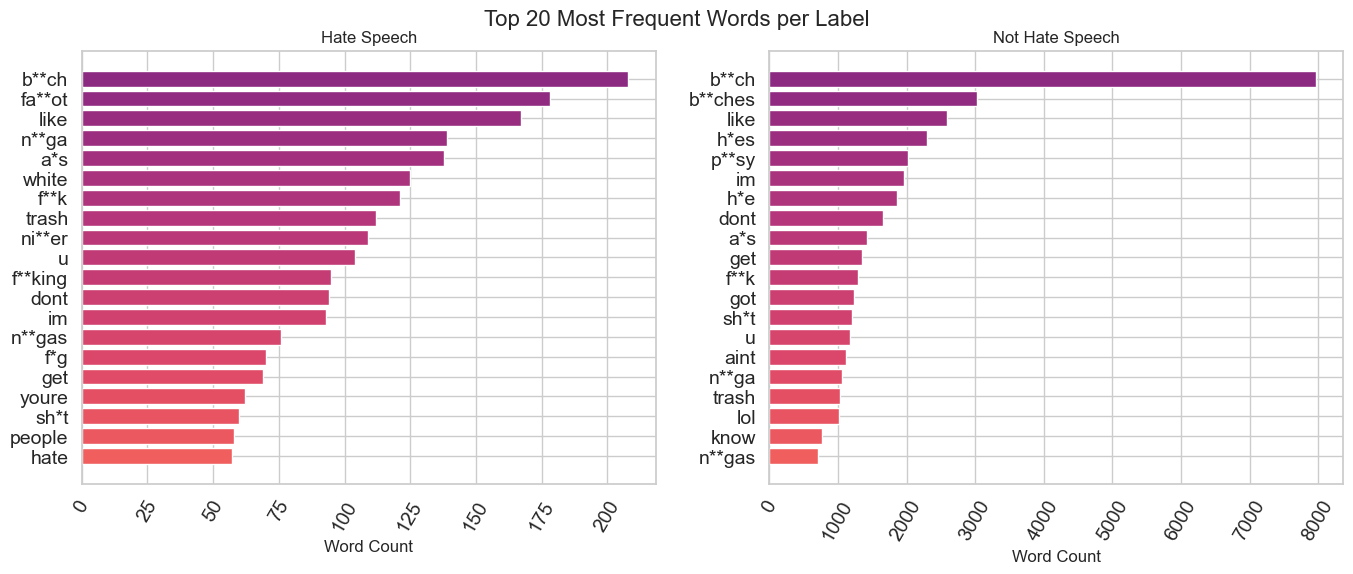

In [22]:
# Create a new figure with two subplots (121 and 122) for side-by-side 
# comparison of hate speech and non-hate speech word frequencies.
new_figure = plt.figure(figsize=(14,6))

# Add the first subplot and invert the y-axis to display the most frequent words at the top.
ax = new_figure.add_subplot(121)
ax.invert_yaxis()

# Add the second subplot and invert the y-axis.
ax2 = new_figure.add_subplot(122)
ax2.invert_yaxis()

# Generate horizontal bar charts on each subplot using the provided data and color gradient.
ax.barh(hate_bar_words, hate_bar_counts, color=color)
ax2.barh(not_hate_bar_words, not_hate_bar_counts, color=color)

# Set titles for both subplots: 'Hate Speech' and 'Not Hate Speech'.
ax.title.set_text('Hate Speech')
ax2.title.set_text('Not Hate Speech')

# Customize the appearance of both subplots, including rotation of x-axis labels, font sizes, and labels.
for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize=14)
    plt.xlabel("Word Count")
    plt.yticks(fontsize=14)
    
# Adjust the layout for better spacing.    
plt.tight_layout(pad=2)

# Add a suptitle for the entire figure.
new_figure.suptitle('Top 20 Most Frequent Words per Label', fontsize=16)

# Save the figure as an image and display it.
plt.savefig('U:/Lip22pri/Dissertation/label_word_count_y.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

### what are only hate words?

In [23]:
# Define a function that returns elements in list 'a' that are not in list 'b'
def returnNotMatches(a, b):
    return [x for x in a if x not in b]

# Call the function to find elements unique to 'flat_hate' compared to 'flat_not_hate'
result_list = returnNotMatches(flat_hate, flat_not_hate)

# Display only the first, say, 10 elements of the result list
print(result_list[:10])


['gaywad', 'alsarabsss', 'blacklisted', 'xuccwoetmn', 'ariza', 'drakes', 'nikejordan', 'glitter', 'qctplxhexm', 'la*sen']


### Wordclouds

In [24]:
# Create a dictionary 'hate_dict' by combining 'hate_bar_words' (words) and 'hate_bar_counts' (word counts)
hate_dict = dict(zip(hate_bar_words, hate_bar_counts))

# Create a dictionary 'not_hate_dict' by combining 'not_hate_bar_words' (words) and 'not_hate_bar_counts' (word counts)
not_hate_dict = dict(zip(not_hate_bar_words, not_hate_bar_counts))

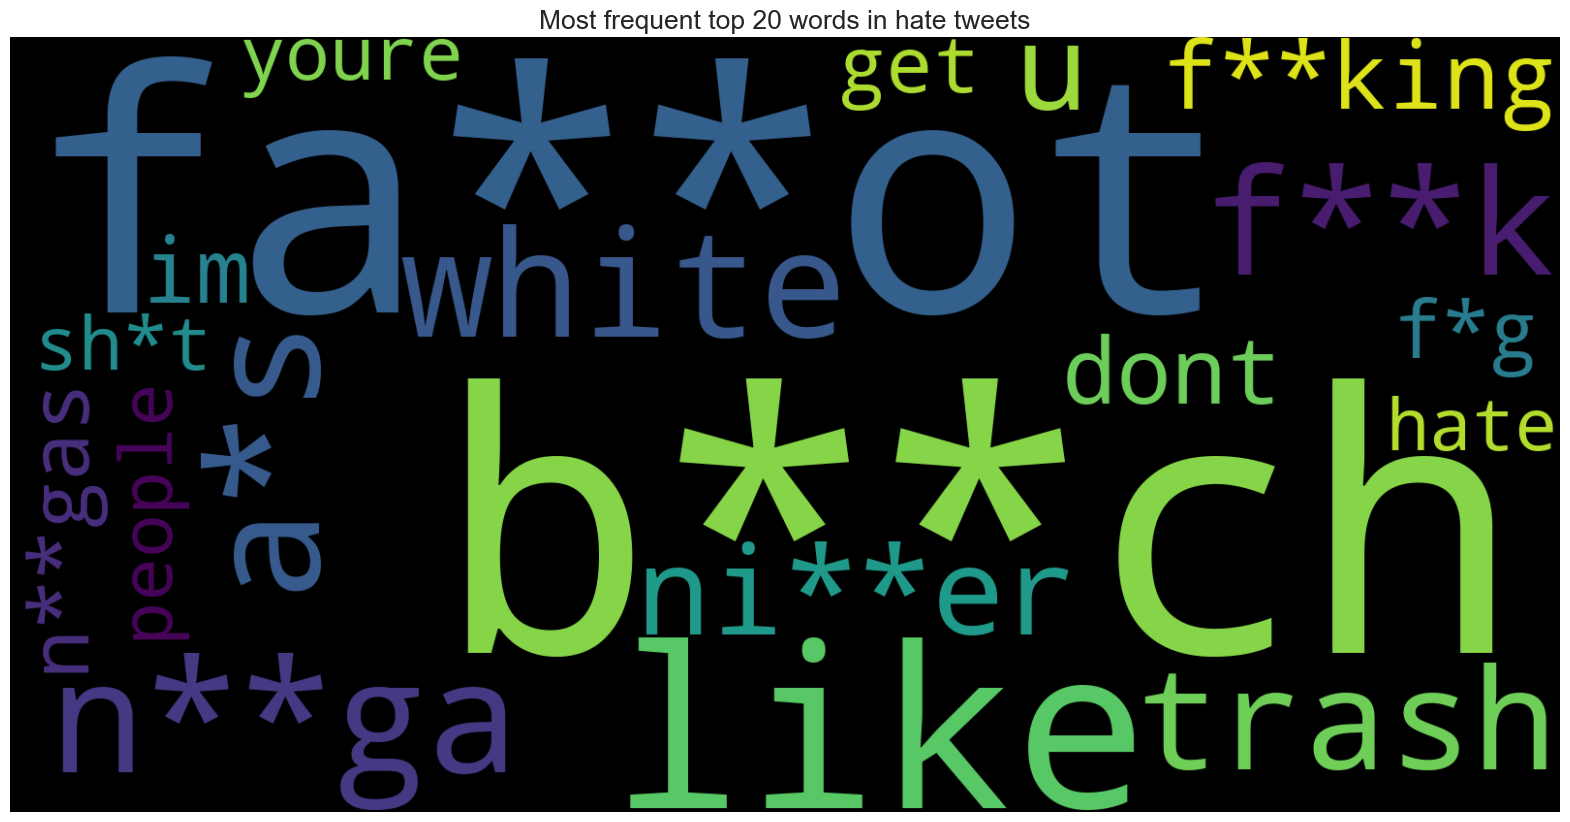

In [25]:
# Create a WordCloud object with customization options like maximum words, width, and height.
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate_from_frequencies(hate_dict)

# Create a figure with a specified size and no background color.
plt.figure(figsize=(20, 15), facecolor='None')

# Display the word cloud image with interpolation method set to 'bilinear'.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Set the title for the word cloud.
plt.title('Most frequent top 20 words in hate tweets', fontsize = 19)

# Save the word cloud image to a file.
plt.savefig('U:/Lip22pri/Dissertation/hatespeech_cloud_20.png')

# Show the word cloud.
plt.show()

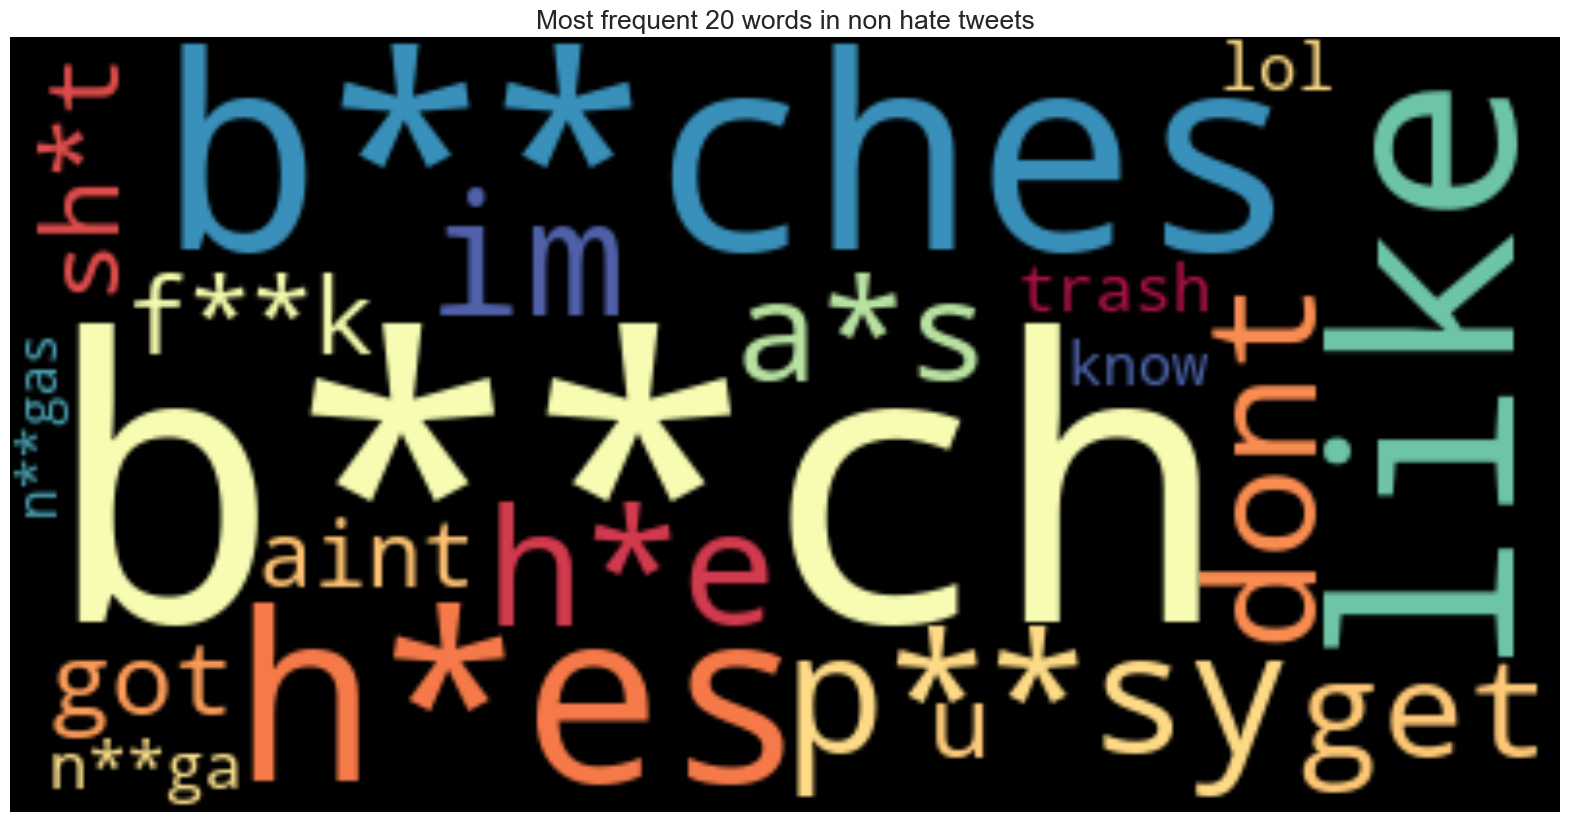

In [26]:
# Create a WordCloud object with a specific colormap.
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_hate_dict)

# Create a figure with a specified size and no background color.
plt.figure(figsize=(20, 15), facecolor='None')

# Display the word cloud image with interpolation method set to 'bilinear'.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Set the title for the word cloud.
plt.title('Most frequent 20 words in non hate tweets', fontsize = 19)

# Save the word cloud image to a file.
plt.savefig('U:/Lip22pri/Dissertation/non_hatespeech_cloud_20.png')

# Show the word cloud.
plt.show()

### Bigrams

In [27]:
# Define a function to generate bigrams from a given text
def generate_bigrams(text):
    # Generate bigrams using the ngrams function
    bigrams = list(ngrams(text, 2))   
    return bigrams

# flat_filtered is the text from which bigrams will be generated
# bigrams will store the generated bigrams
bigrams = generate_bigrams(flat_filtered_censor)

# Count the frequency of bigrams using the Counter function
bigram_freq = Counter(bigrams)

# Get the 20 most common bigrams and their frequencies
most_common_bigrams = bigram_freq.most_common(20)

# Print the most common bigrams and their frequencies
most_common_bigrams

[(('b**ch', 'a*s'), 237),
 (('like', 'b**ch'), 222),
 (('b**ch', 'im'), 216),
 (('look', 'like'), 201),
 (('a*s', 'b**ch'), 199),
 (('yo', 'b**ch'), 192),
 (('bad', 'b**ch'), 180),
 (('b**ch', 'dont'), 178),
 (('bad', 'b**ches'), 143),
 (('b**ch', 'b**ch'), 137),
 (('a*s', 'n**ga'), 133),
 (('b**ch', 'aint'), 125),
 (('h*es', 'aint'), 125),
 (('f**k', 'b**ch'), 124),
 (('little', 'b**ch'), 123),
 (('b**ch', 'n**ga'), 105),
 (('b**ch', 'got'), 104),
 (('b**ch', 'like'), 103),
 (('dont', 'know'), 103),
 (('white', 'trash'), 101)]

### Trigrams

In [28]:
# Define a function to generate trigrams from a given text
def generate_trigrams(text):
    trigrams = list(ngrams(text, 3))
    
    return trigrams

# flat_filtered_censor is the text from which trigrams will be generated
# trigrams will store the generated trigrams
trigrams = generate_trigrams(flat_filtered_censor)

# Count the frequency of trigrams using the Counter function
trigram_freq = Counter(trigrams)

# Get the 20 most common trigrams and their frequencies
most_common_trigrams = trigram_freq.most_common(20)

# Print the most common trigrams and their frequencies
most_common_trigrams


[(('h*es', 'aint', 'loyal'), 63),
 (('b**ch', 'a*s', 'n**ga'), 53),
 (('dont', 'love', 'h*es'), 32),
 (('b**ch', 'look', 'like'), 26),
 (('b**ches', 'thing', 'like'), 24),
 (('f**k', 'right', 'p**sy'), 24),
 (('yo', 'b**ch', 'a*s'), 23),
 (('stupid', 'a*s', 'b**ch'), 23),
 (('bad', 'b**ches', 'thing'), 20),
 (('h*e', 'a*s', 'n**ga'), 20),
 (('a*s', 'b**ch', 'aint'), 19),
 (('best', 'asian', 'ma*sage'), 19),
 (('park', 'slope', 'top'), 19),
 (('slope', 'top', 'rated'), 19),
 (('top', 'rated', 'spa'), 19),
 (('dont', 'give', 'f**k'), 18),
 (('b**ches', 'aint', 'sh*t'), 17),
 (('like', 'little', 'b**ch'), 15),
 (('b**ch', 'dont', 'like'), 15),
 (('f**k', 'yo', 'b**ch'), 14)]

## Model Building

### Splitting data 

tweet_df -> x_temp, x_test        
x_temp -> x_train, x_cv

we get  x_temp, x_train, x_cv, x_test    

In [29]:
# Assign the feature data (X_lem) and labels (y_lem) to variables X and y.
X = X_lem
y = y_lem

# Split the data into different subsets for training, cross-validation, and testing.

# First, create a temporary dataset (X_temp, y_temp) by splitting the original data (X and y).
# The test_size parameter specifies that 30% of the data will be used for testing.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Next, split the temporary dataset (X_temp, y_temp) into training (X_train, y_train) and
# cross-validation (X_cv, y_cv) datasets.
# Here, 70% of the data from X_temp will be used for training, and 30% for cross-validation.
X_train, X_cv, y_train, y_cv = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

## Cross Validation

In [30]:
# Vectorize the textual data using TF-IDF (Term Frequency-Inverse Document Frequency)
# This transforms the text data into numerical features suitable for machine learning.
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data (X_train) into a TF-IDF vectorized format.
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)

# Transform the cross-validation data (X_cv) into the same TF-IDF vectorized format.
X_cv_vectorized = tfidf_vectorizer.transform(X_cv)

# Perform resampling on the vectorized training data using SMOTE.
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the vectorized training data (X_train_vectorized) and corresponding labels (y_train).
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

## Unigram Models

### SVM

SVM Accuracy: 0.9404945904173106
SVM Precision: 0.9100372842004727
SVM Recall: 0.9404945904173106
SVM Weighted F1 Score: 0.9177930112104052


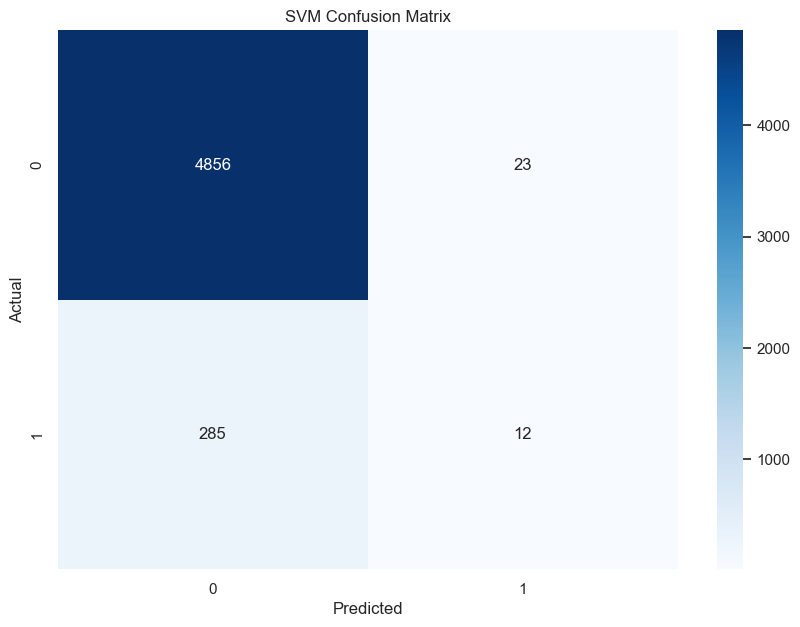

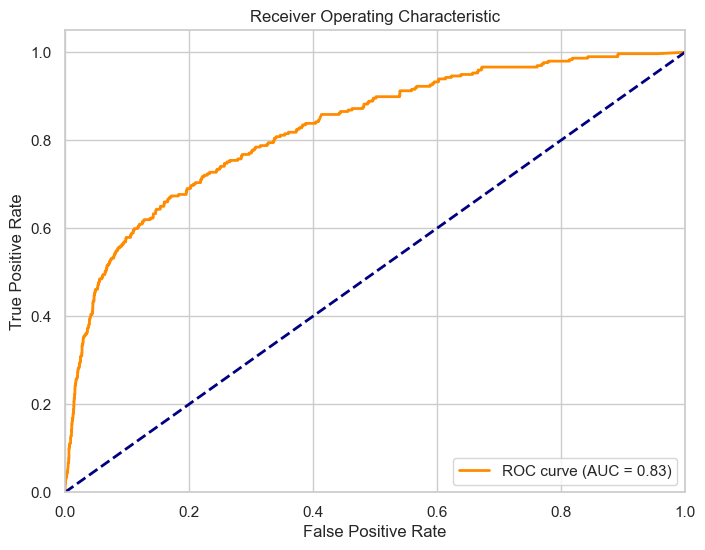

ROC AUC Score: 0.83


In [31]:
# Create and fit a Support Vector Machine (SVM) classifier with specified hyperparameters.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
svm_model = SVC(C=1.0,kernel='linear',probability=True,degree=3,gamma='auto',random_state=20)
svm_model.fit(X_train_resampled, y_train_resampled)

# Perform k-fold cross-validation on the cross-validation set (X_cv_vectorized).
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
svm_val_predictions = cross_val_predict(svm_model, X_cv_vectorized, y_cv, cv=kf)

# Calculate various evaluation metrics.
svm_accuracy = accuracy_score(y_cv, svm_val_predictions)
svm_precision = precision_score(y_cv, svm_val_predictions, average='weighted')
svm_recall = recall_score(y_cv, svm_val_predictions, average='weighted')
svm_f1_weight = f1_score(y_cv, svm_val_predictions, average='weighted')

# Print the calculated metrics.
print(f"SVM Accuracy: {svm_accuracy}")
print(f"SVM Precision: {svm_precision}")
print(f"SVM Recall: {svm_recall}")
print(f"SVM Weighted F1 Score: {svm_f1_weight}")

# Plot a confusion matrix to visualize classification results.
svm_cm = confusion_matrix(y_cv, svm_val_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate and plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC).
svm_cv_probs = svm_model.predict_proba(X_cv_vectorized)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_cv, svm_cv_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_svm:.2f}")


### RF

Random Forest Accuracy: 0.9406877897990726
Random Forest Precision: 0.9035814054363218
Random Forest Recall: 0.9406877897990726
Random Weighted F1 Score: 0.9155923889592781


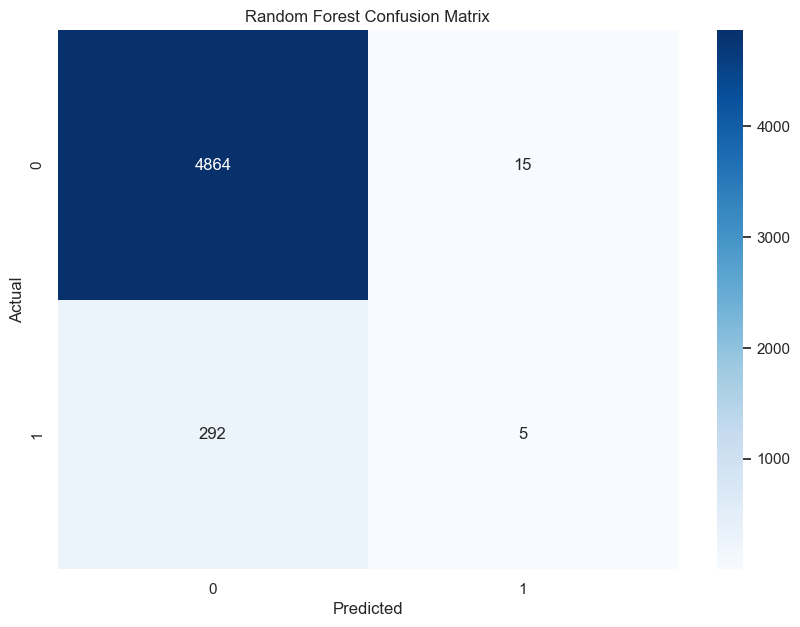

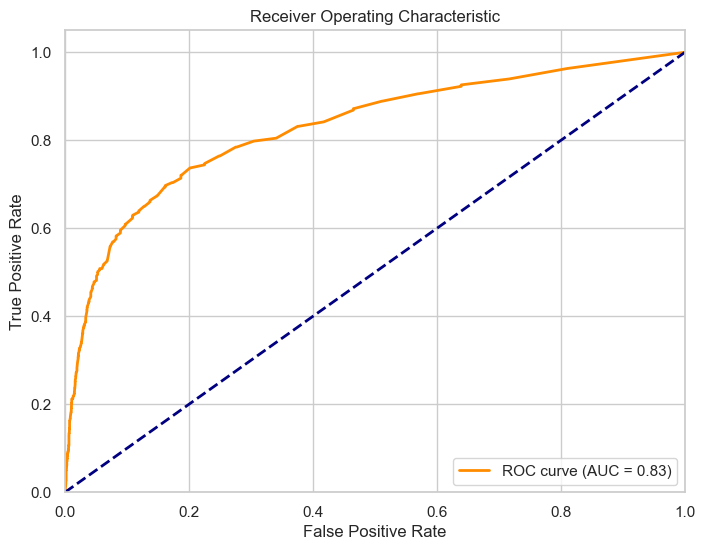

ROC AUC Score: 0.83


In [32]:
# Create and fit a Random Forest classifier with specified hyperparameters
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Perform k-fold cross-validation on the cross-validation set (X_cv_vectorized)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
rf_val_predictions = cross_val_predict(rf_model, X_cv_vectorized, y_cv, cv=kf)

# Calculate various evaluation metrics for the Random Forest classifier
rf_accuracy = accuracy_score(y_cv, rf_val_predictions)
rf_precision = precision_score(y_cv, rf_val_predictions, average='weighted')
rf_recall = recall_score(y_cv, rf_val_predictions, average='weighted')
# rf_f1 = f1_score(y_cv, rf_val_predictions)
rf_f1_weight = f1_score(y_cv, rf_val_predictions, average='weighted')


# Print the calculated metrics
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Precision: {rf_precision}")
print(f"Random Forest Recall: {rf_recall}")
# print(f"Random Forest F1 Score: {rf_f1}")
print(f"Random Weighted F1 Score: {rf_f1_weight}")


# Plot a confusion matrix to visualize classification results
rf_cm = confusion_matrix(y_cv, rf_val_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate and plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC)
rf_cv_probs = rf_model.predict_proba(X_cv_vectorized)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_cv, rf_cv_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score for the Random Forest classifier
print(f"ROC AUC Score: {roc_auc_rf:.2f}")


## Bigrams Models

In [33]:
# Create a TF-IDF vectorizer that considers bigrams (2-grams)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))

# Vectorize the training and cross-validation data using the bigram TF-IDF vectorizer
X_train_vectorized_bi = tfidf_vectorizer.fit_transform(X_train)
X_cv_vectorized_bi = tfidf_vectorizer.transform(X_cv)

# Perform resampling on the vectorized training data using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample the training data with bigram vectorization
X_train_resampled_bi, y_train_resampled = smote.fit_resample(X_train_vectorized_bi, y_train)

### SVM

SVM Accuracy: 0.9433925811437404
SVM Precision: 0.9241084577177598
SVM Recall: 0.9433925811437404
SVM Weighted F1 Score: 0.9204103186198412


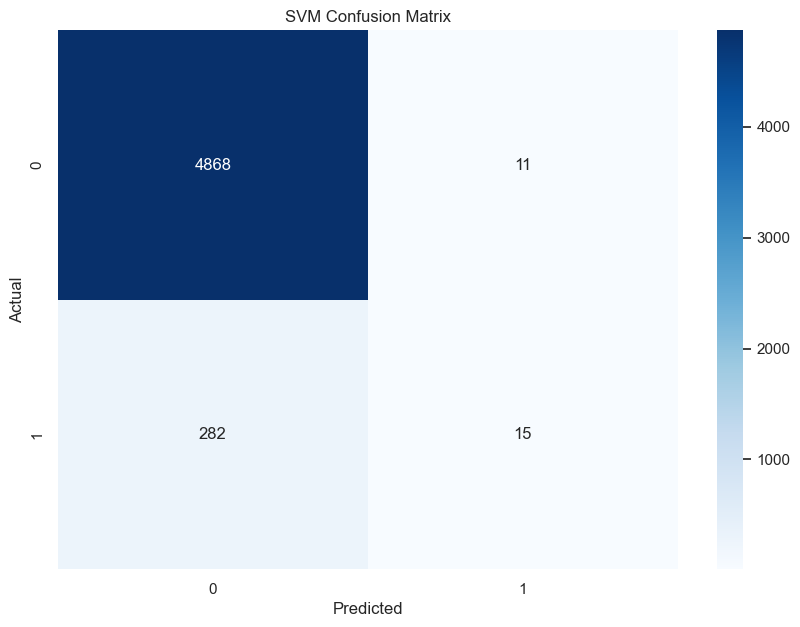

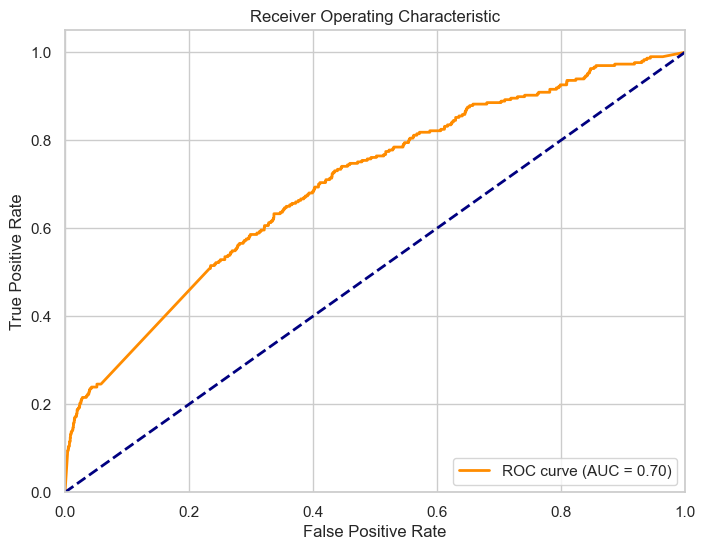

ROC AUC Score: 0.70


In [34]:
# Create an SVM classifier with a linear kernel and other specified settings
svm_model = SVC(C=1.0,kernel='linear',probability=True,degree=3,gamma='auto',random_state=20)

# Fit the SVM model on the resampled training data with bigrams
svm_model.fit(X_train_resampled_bi, y_train_resampled)

# Perform k-fold cross-validation on the cross-validation set
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
svm_val_predictions = cross_val_predict(svm_model, X_cv_vectorized_bi, y_cv, cv=kf)

# Calculate various classification metrics for the cross-validation predictions
svm_accuracy = accuracy_score(y_cv, svm_val_predictions)
svm_precision = precision_score(y_cv, svm_val_predictions, average='weighted')
svm_recall = recall_score(y_cv, svm_val_predictions, average='weighted')
# svm_f1 = f1_score(y_cv, svm_val_predictions,average='weighted')
svm_f1_weight = f1_score(y_cv, svm_val_predictions, average='weighted')

# Print the calculated metrics
print(f"SVM Accuracy: {svm_accuracy}")
print(f"SVM Precision: {svm_precision}")
print(f"SVM Recall: {svm_recall}")
# print(f"SVM F1 Score: {svm_f1:.2f}")
print(f"SVM Weighted F1 Score: {svm_f1_weight}")

# Plot the confusion matrix
svm_cm = confusion_matrix(y_cv, svm_val_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate the Receiver Operating Characteristic (ROC) curve and calculate AUC
svm_cv_probs = svm_model.predict_proba(X_cv_vectorized_bi)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_cv, svm_cv_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_svm:.2f}")

## RF

Random Forest Accuracy: 0.9437789799072643
Random Forest Precision: 0.9257467715722283
Random Forest Recall: 0.9437789799072643
Random Weighted F1 Score: 0.9218799948788434


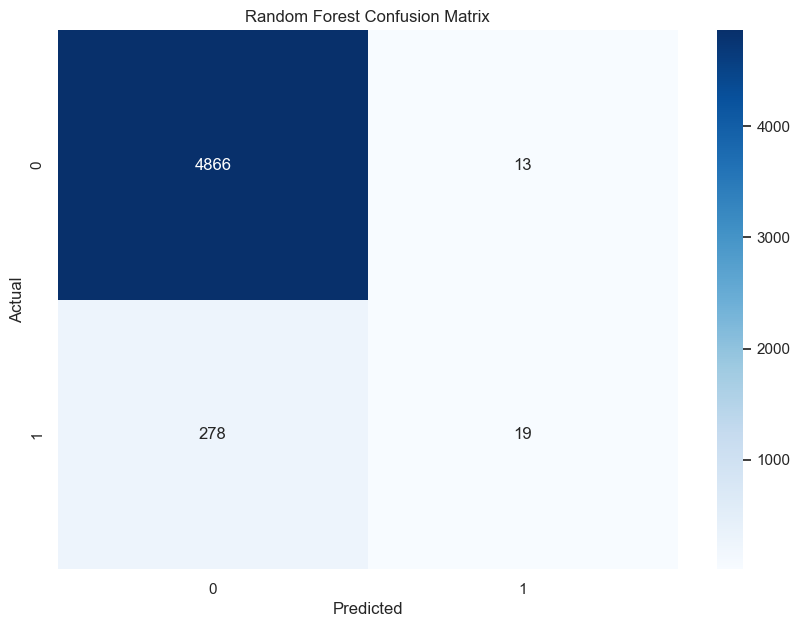

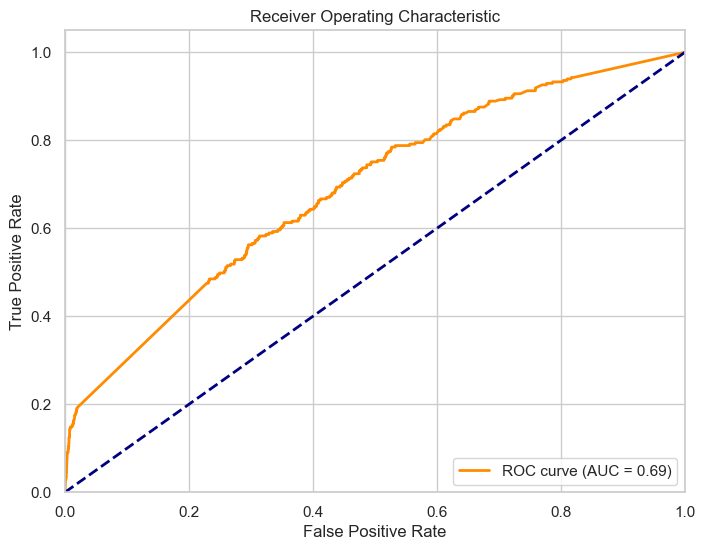

ROC AUC Score: 0.69


In [35]:
# Create and fit a Random Forest classifier with 100 estimators and a specified random state
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)

# Fit the Random Forest model on the resampled training data with bigrams
rf_model.fit(X_train_resampled_bi, y_train_resampled)

# Perform k-fold cross-validation on the cross-validation set
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
rf_val_predictions = cross_val_predict(rf_model, X_cv_vectorized_bi, y_cv, cv=kf)

# Calculate various classification metrics for the cross-validation predictions
rf_accuracy = accuracy_score(y_cv, rf_val_predictions)
rf_precision = precision_score(y_cv, rf_val_predictions, average='weighted')
rf_recall = recall_score(y_cv, rf_val_predictions, average='weighted')
rf_f1_weight = f1_score(y_cv, rf_val_predictions, average='weighted')


# Print metrics
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Precision: {rf_precision}")
print(f"Random Forest Recall: {rf_recall}")
print(f"Random Weighted F1 Score: {rf_f1_weight}")


# Print the calculated metrics
rf_cm = confusion_matrix(y_cv, rf_val_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate the Receiver Operating Characteristic (ROC) curve and calculate AUC
rf_cv_probs = rf_model.predict_proba(X_cv_vectorized_bi)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_cv, rf_cv_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_rf:.2f}")


## Trigram Models

In [36]:
# Create a TF-IDF vectorizer with trigrams (ngram_range=(3, 3))
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 3))

# Vectorize the training data using the trigram TF-IDF vectorizer
X_train_vectorized_tri = tfidf_vectorizer.fit_transform(X_train)

# Vectorize the cross-validation data using the same vectorizer
X_cv_vectorized_tri = tfidf_vectorizer.transform(X_cv)

# Perform resampling on the vectorized training data using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample the training data with trigram vectorization
X_train_resampled_tri, y_train_resampled = smote.fit_resample(X_train_vectorized_tri, y_train)

### SVM

SVM Accuracy: 0.9426197836166924
SVM Precision: 0.9175448422787784
SVM Recall: 0.9426197836166924
SVM Weighted F1 Score: 0.9155285579782436


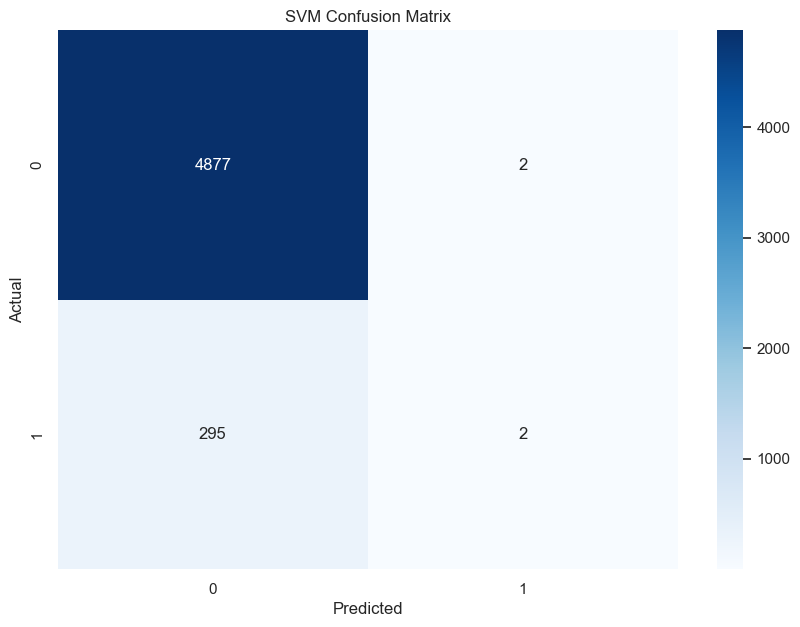

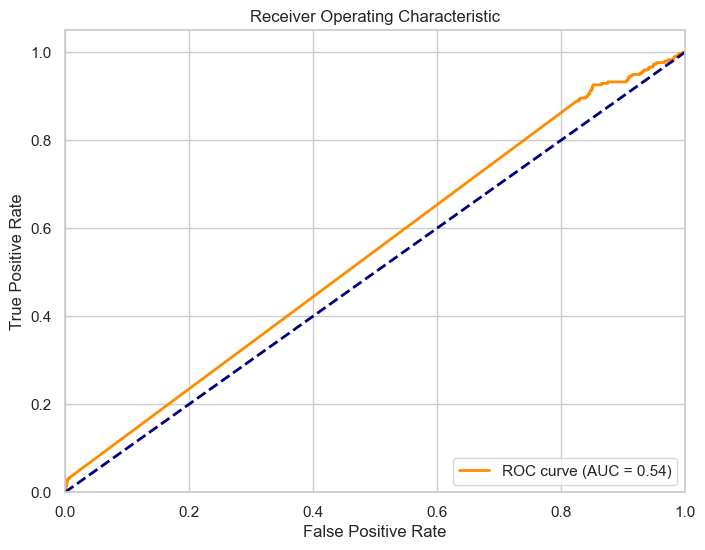

ROC AUC Score: 0.54


In [37]:
# Create an SVM classifier with specified hyperparameters
svm_model = SVC(C=1.0,kernel='linear',probability=True,degree=3,gamma='auto',random_state=20)

# Fit the SVM model to the resampled training data with trigram vectorization
svm_model.fit(X_train_resampled_tri, y_train_resampled)

# Perform k-fold cross-validation on the cross-validation set
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
svm_val_predictions = cross_val_predict(svm_model, X_cv_vectorized_tri, y_cv, cv=kf)

# Calculate various classification metrics
svm_accuracy = accuracy_score(y_cv, svm_val_predictions)
svm_precision = precision_score(y_cv, svm_val_predictions, average='weighted')
svm_recall = recall_score(y_cv, svm_val_predictions, average='weighted')
svm_f1_weight = f1_score(y_cv, svm_val_predictions, average='weighted')

# Print the calculated metrics
print(f"SVM Accuracy: {svm_accuracy}")
print(f"SVM Precision: {svm_precision}")
print(f"SVM Recall: {svm_recall}")
print(f"SVM Weighted F1 Score: {svm_f1_weight}")

# Plot the confusion matrix
svm_cm = confusion_matrix(y_cv, svm_val_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate and display the ROC curve and AUC score
svm_cv_probs = svm_model.predict_proba(X_cv_vectorized_tri)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_cv, svm_cv_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_svm:.2f}")

### RF

Random Forest Accuracy: 0.9416537867078826
Random Forest Precision: 0.9015538659469245
Random Forest Recall: 0.9416537867078826
Random Weighted F1 Score: 0.9150330834738076


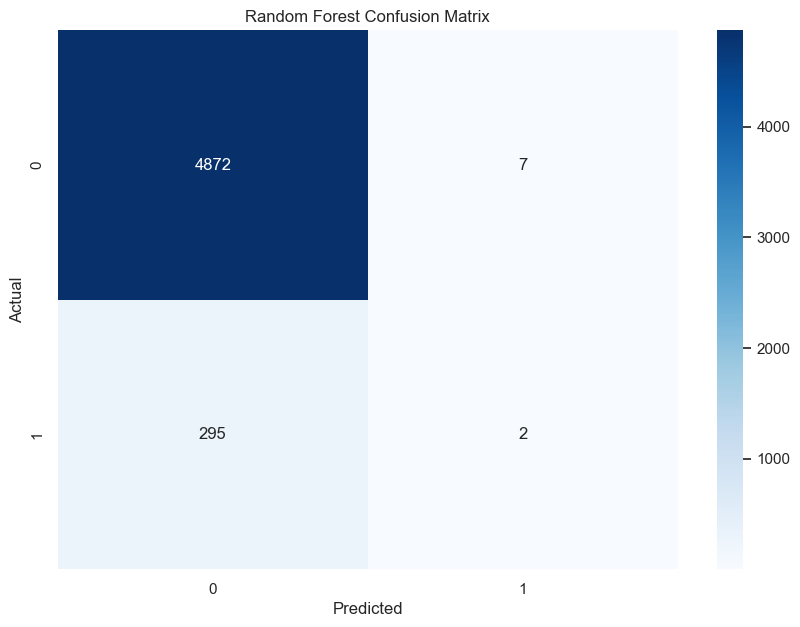

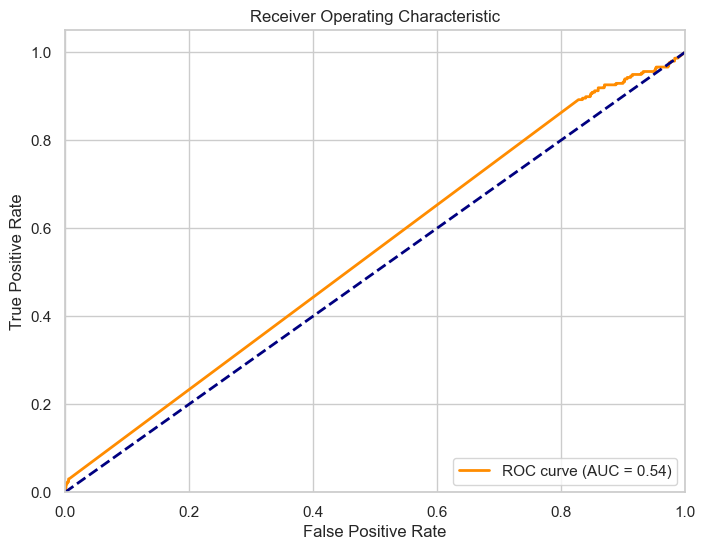

ROC AUC Score: 0.54


In [38]:
# Create and fit a Random Forest classifier with 100 estimators
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train_resampled_tri, y_train_resampled)

# Perform k-fold cross-validation to make predictions and calculate metrics
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
rf_val_predictions = cross_val_predict(rf_model, X_cv_vectorized_tri, y_cv, cv=kf)

# Calculate accuracy, precision, recall, and weighted F1-score
rf_accuracy = accuracy_score(y_cv, rf_val_predictions)
rf_precision = precision_score(y_cv, rf_val_predictions, average='weighted')
rf_recall = recall_score(y_cv, rf_val_predictions, average='weighted')
rf_f1_weight = f1_score(y_cv, rf_val_predictions, average='weighted')


# Print the calculated metrics
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Precision: {rf_precision}")
print(f"Random Forest Recall: {rf_recall}")
print(f"Random Weighted F1 Score: {rf_f1_weight}")


# Plot the confusion matrix
rf_cm = confusion_matrix(y_cv, rf_val_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate and display the ROC curve with the AUC score
rf_cv_probs = rf_model.predict_proba(X_cv_vectorized_tri)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_cv, rf_cv_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_rf:.2f}")


## Testing

In [39]:
# Vectorize the textual data using TF-IDF (Term Frequency-Inverse Document Frequency)
tfidf_vectorizer = TfidfVectorizer()

# TF-IDF vectorization of the temporary dataset
X_temp_vectorized = tfidf_vectorizer.fit_transform(X_temp)

# TF-IDF vectorization of the test dataset
X_test_vectorized = tfidf_vectorizer.transform(X_test)

# Resampling the temporary dataset using SMOTE
X_temp_resampled, y_temp_resampled = smote.fit_resample(X_temp_vectorized, y_temp)

Unigram SVM and RF models show better result than others. 

Hence training both models on original train data(X_temp) and testing it on test data(X_test)

SVM Accuracy: 0.8715348208248817
SVM Precision: 0.9296406928148373
SVM Recall: 0.8715348208248817
SVM Weighted F1 Score: 0.8949709100846652


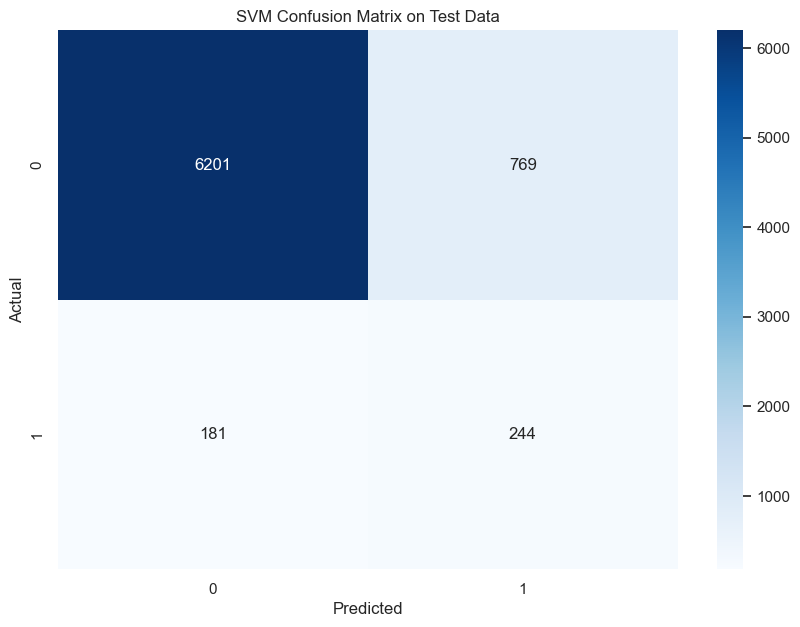

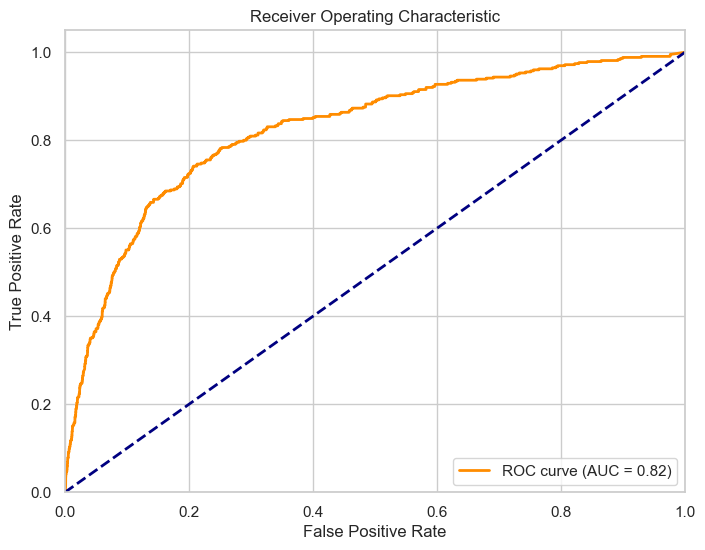

ROC AUC Score: 0.82


In [40]:
# Train and fit SVM model on training data
svm_model2 = SVC(C=1.0,kernel='linear',probability=True,degree=3,gamma='auto',random_state=20)
svm_model2.fit(X_temp_resampled, y_temp_resampled)

# Predict on test set
svm_val_predictions2 = svm_model2.predict(X_test_vectorized)

# Calculate various classification metrics
svm_accuracy2 = accuracy_score(y_test, svm_val_predictions2)
svm_precision2 = precision_score(y_test, svm_val_predictions2, average='weighted')
svm_recall2 = recall_score(y_test, svm_val_predictions2, average='weighted')
svm_f1_weight2 = f1_score(y_test, svm_val_predictions2, average='weighted')

# Print the calculated metrics
print(f"SVM Accuracy: {svm_accuracy2}")
print(f"SVM Precision: {svm_precision2}")
print(f"SVM Recall: {svm_recall2}")
print(f"SVM Weighted F1 Score: {svm_f1_weight2}")

# Plot confusion matrix
svm_cm2 = confusion_matrix(y_test, svm_val_predictions2)
plt.figure(figsize=(10,7))
sns.heatmap(svm_cm2, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix on Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate ROC curve and calculate AUC
svm_cv_probs2 = svm_model2.predict_proba(X_test_vectorized)[:, 1]
fpr_svm2, tpr_svm2, thresholds_svm2 = roc_curve(y_test, svm_cv_probs2)
roc_auc_svm2 = auc(fpr_svm2, tpr_svm2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm2, tpr_svm2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svm2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_svm2:.2f}")


Random Forest Accuracy: 0.9219743069641649
Random Forest Precision: 0.9213685240457936
Random Forest Recall: 0.9219743069641649
Random Weighted F1 Score: 0.9216699374240805


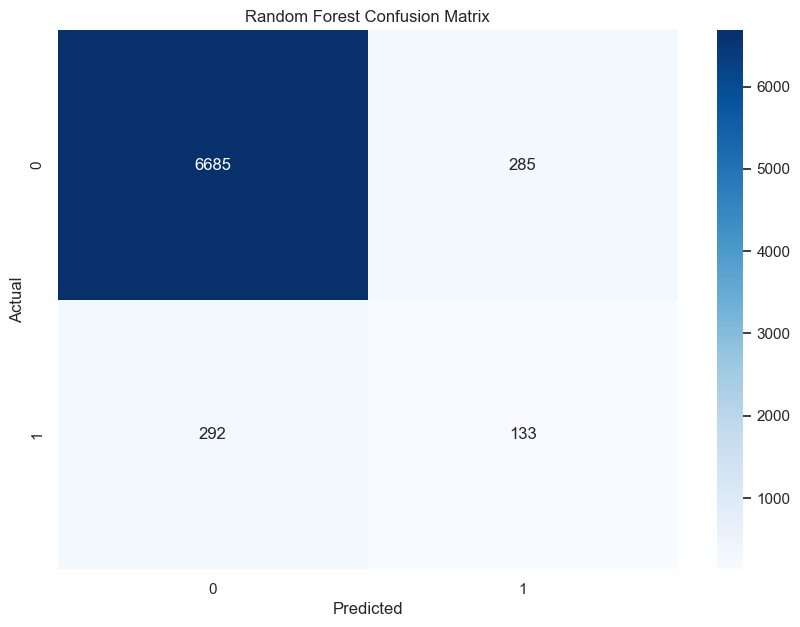

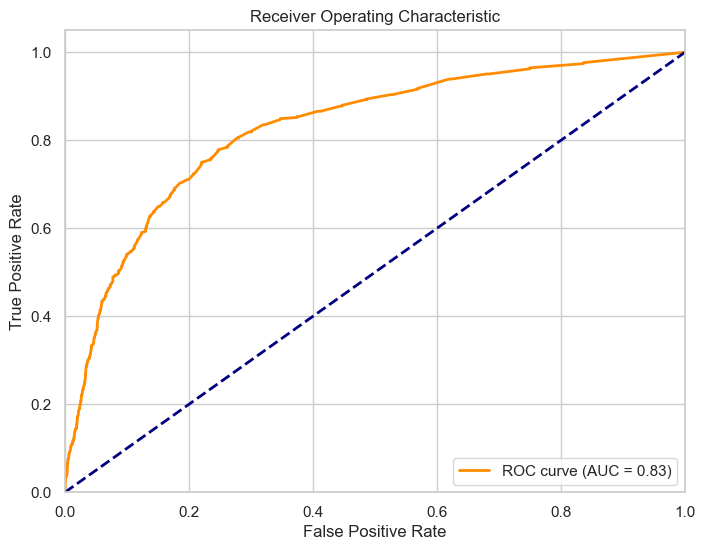

ROC AUC Score: 0.83


In [41]:
# Create and fit a Random Forest classifier with 100 estimators
rf_model2 = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model2.fit(X_temp_resampled, y_temp_resampled)

# Predict on test set
rf_val_predictions2 = rf_model2.predict(X_test_vectorized)

# Calculate metrics
rf_accuracy2 = accuracy_score(y_test, rf_val_predictions2)
rf_precision2 = precision_score(y_test, rf_val_predictions2, average='weighted')
rf_recall2 = recall_score(y_test, rf_val_predictions2, average='weighted')
# rf_f1 = f1_score(y_test, rf_val_predictions2)
rf_f1_weight2 = f1_score(y_test, rf_val_predictions2, average='weighted')


# Print metrics
print(f"Random Forest Accuracy: {rf_accuracy2}")
print(f"Random Forest Precision: {rf_precision2}")
print(f"Random Forest Recall: {rf_recall2}")
# print(f"Random Forest F1 Score: {rf_f1}")
print(f"Random Weighted F1 Score: {rf_f1_weight2}")


# Plot confusion matrix
rf_cm2 = confusion_matrix(y_test, rf_val_predictions2)
plt.figure(figsize=(10,7))
sns.heatmap(rf_cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate ROC curve and calculate AUC
rf_cv_probs2 = rf_model2.predict_proba(X_test_vectorized)[:, 1]
fpr_rf2, tpr_rf2, thresholds_rf2 = roc_curve(y_test, rf_cv_probs2)
roc_auc_rf2 = auc(fpr_rf2, tpr_rf2)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf2, tpr_rf2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc_rf2:.2f}")